In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),  
            self._block(features_g * 16, features_g * 8, 4, 2, 1), 
            self._block(features_g * 8, features_g * 4, 4, 2, 1), 
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)



In [3]:
class Discriminator(nn.Module):
  def __init__(self,channel_img, features_d):
    super(Discriminator,self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(channel_img, features_d,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(features_d, features_d*2,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(features_d*2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(features_d*2, features_d*4,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(features_d*4),
        nn.LeakyReLU(0.2),
        nn.Conv2d(features_d*4, features_d*8,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(features_d*8),
        nn.LeakyReLU(0.2),
        nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0),
        nn.Sigmoid(),
    )
  
  def forward(self,x):
    return self.main(x)


In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4 
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
GEN_LOSS = []
DISC_LOSS = []

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms,
                       download=True)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (12): Sigmoid()
  )
)

In [6]:
for epoch in range(NUM_EPOCHS):
    
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            GEN_LOSS.append(loss_gen)
            DISC_LOSS.append(loss_disc)

            with torch.no_grad():
                fake = gen(fixed_noise)
                
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [1/5] Batch 0/469                   Loss D: 0.6878, loss G: 0.8018
Epoch [1/5] Batch 100/469                   Loss D: 0.3497, loss G: 2.2482
Epoch [1/5] Batch 200/469                   Loss D: 0.6622, loss G: 1.1674
Epoch [1/5] Batch 300/469                   Loss D: 0.4767, loss G: 2.1761
Epoch [1/5] Batch 400/469                   Loss D: 0.5395, loss G: 2.3083
Epoch [2/5] Batch 0/469                   Loss D: 0.6949, loss G: 1.0564
Epoch [2/5] Batch 100/469                   Loss D: 0.6653, loss G: 1.2474
Epoch [2/5] Batch 200/469                   Loss D: 0.4528, loss G: 1.2296
Epoch [2/5] Batch 300/469                   Loss D: 0.7087, loss G: 1.8755
Epoch [2/5] Batch 400/469                   Loss D: 0.4846, loss G: 0.7969
Epoch [3/5] Batch 0/469                   Loss D: 0.4733, loss G: 1.1388
Epoch [3/5] Batch 100/469                   Loss D: 0.2451, loss G: 2.6154
Epoch [3/5] Batch 200/469                   Loss D: 0.2879, loss G: 1.6599
Epoch [3/5] Batch 300/469      

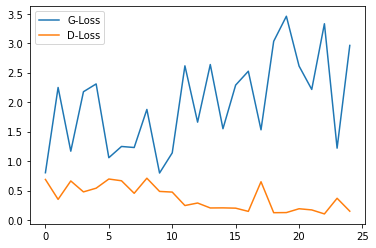

In [7]:
plt.plot(range(len(GEN_LOSS)),GEN_LOSS,label="G-Loss")
plt.plot(range(len(DISC_LOSS)),DISC_LOSS,label="D-Loss")
plt.legend()
plt.show()


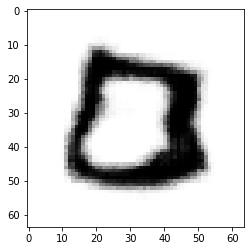

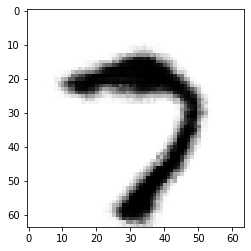

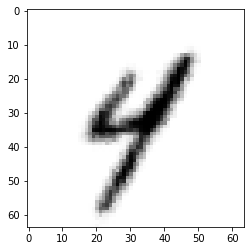

In [10]:
noise = torch.randn((BATCH_SIZE,NOISE_DIM,1,1)).to(device)
img = gen(noise)
img1 = img.cpu()
del img
img1 = img1 / 2 + 0.5     # unnormalize
npimage = img1.detach().numpy()
npimg = npimage[1,0,:,:]
plt.imshow(npimg, cmap='Greys')
plt.show()
npimg = npimage[10,0,:,:]
plt.imshow(npimg, cmap='Greys')
plt.show()
npimg = npimage[20,0,:,:]
plt.imshow(npimg, cmap='Greys')
plt.show()